=== GEOAI CROPLAND MAPPING MODEL ===
Loading and processing 200,000 data samples...
Loading dataset...
Found CSV files: ['Sentinel2.csv', 'SampleSubmission.csv', 'Sentinel1.csv', 'Test.csv']
Loading data from: /kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Sentinel2.csv
Loaded 200000 samples

=== DATA EXPLORATION ===
Dataset shape: (200000, 17)

Column names: ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'ID', 'cloud_pct', 'date', 'solar_azimuth', 'solar_zenith', 'translated_lat', 'translated_lon']

Data types:
B11                 int64
B12                 int64
B2                  int64
B3                  int64
B4                  int64
B5                  int64
B6                  int64
B7                  int64
B8                  int64
B8A                 int64
ID                 object
cloud_pct         float64
date               object
solar_azimuth     float64
solar_zenith      float64
translated_lat    float64
translated_lon    float64
dtype: 

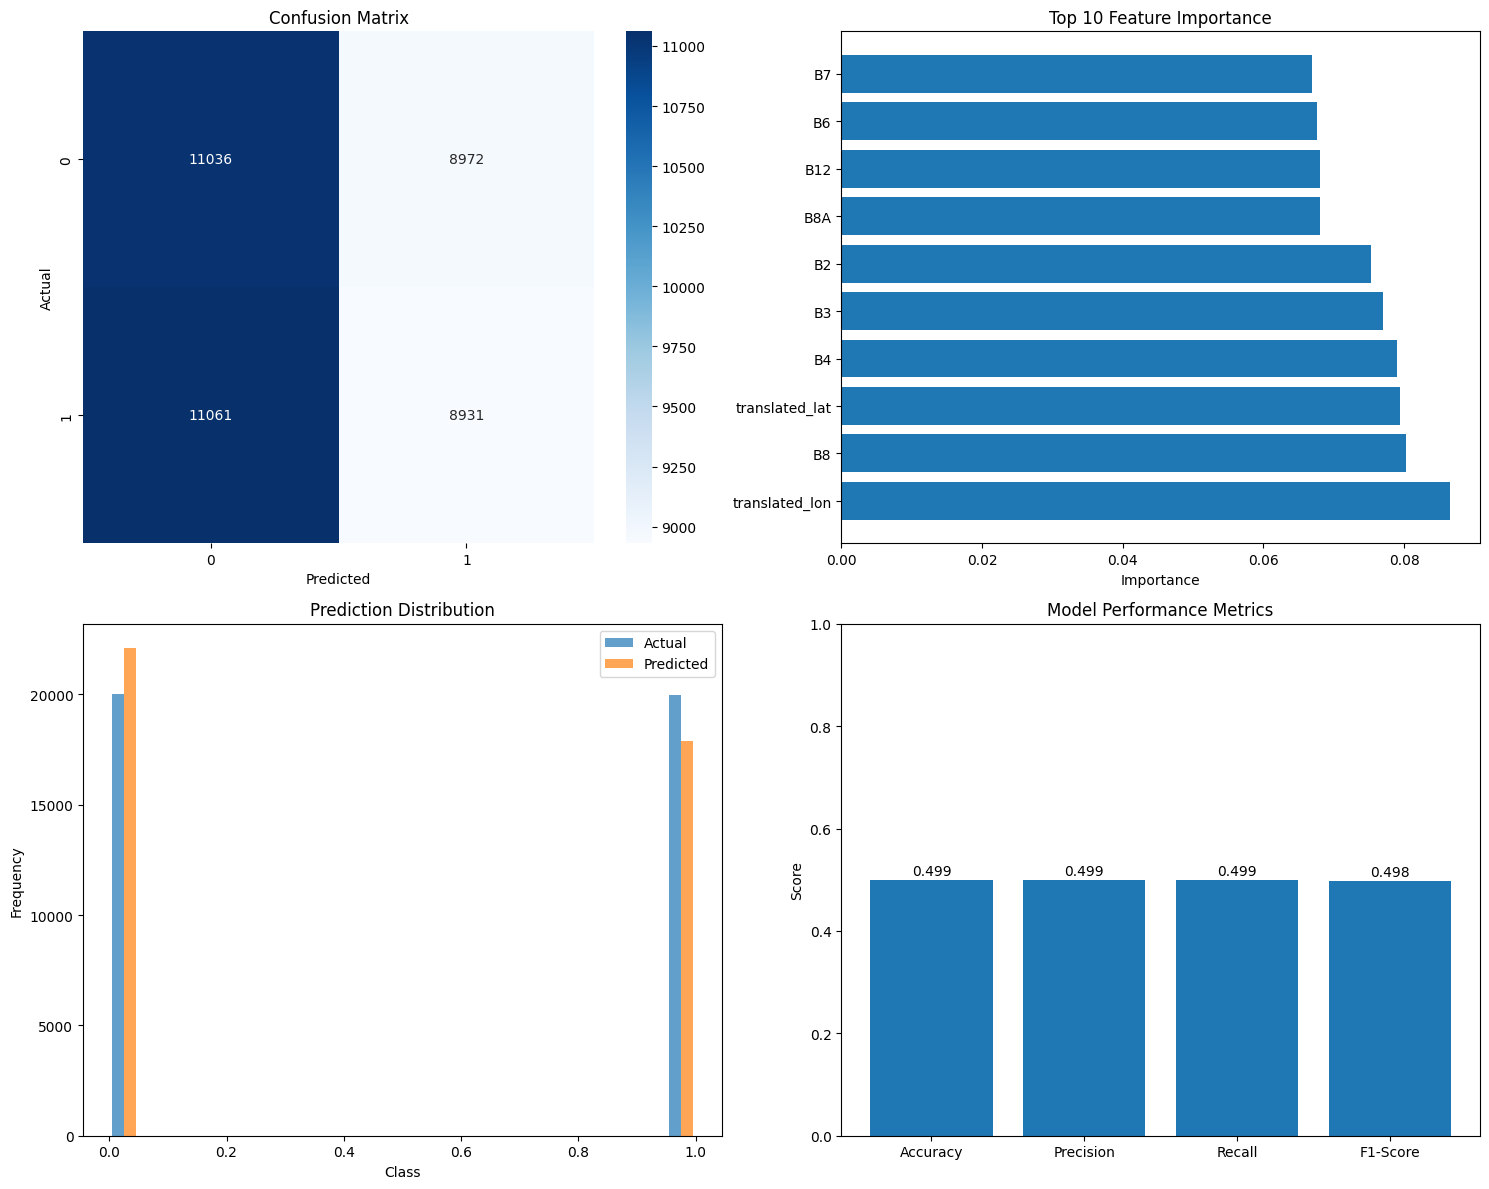


=== PIPELINE COMPLETED ===
Model training and evaluation completed successfully!


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class CroplandMappingModel:
    def __init__(self, data_path='/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset'):
        self.data_path = data_path
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_columns = []
        self.target_column = None
        
    def load_data(self, max_samples=200000):
        """Load and explore the dataset"""
        print("Loading dataset...")
        
        # Try to find CSV files in the dataset directory
        import os
        csv_files = []
        if os.path.exists(self.data_path):
            for file in os.listdir(self.data_path):
                if file.endswith('.csv'):
                    csv_files.append(file)
        
        print(f"Found CSV files: {csv_files}")
        
        # Load the main dataset (assuming there's a test or train CSV)
        # Common names for cropland mapping datasets
        possible_files = ['test.csv', 'train.csv', 'data.csv', 'cropland_data.csv']
        
        data_file = None
        for file in possible_files:
            if file in csv_files:
                data_file = file
                break
        
        if not data_file and csv_files:
            data_file = csv_files[0]  # Use the first CSV file found
            
        if data_file:
            file_path = os.path.join(self.data_path, data_file)
            print(f"Loading data from: {file_path}")
            
            # Load data with sample limit
            df = pd.read_csv(file_path, nrows=max_samples)
            print(f"Loaded {len(df)} samples")
            
        else:
            # Create sample data structure for demonstration
            print("No CSV file found. Creating sample data structure...")
            df = self.create_sample_data(max_samples)
            
        return df
    
    def create_sample_data(self, n_samples=200000):
        """Create sample cropland data for demonstration"""
        np.random.seed(42)
        
        # Generate realistic cropland mapping features
        data = {
            'longitude': np.random.uniform(-180, 180, n_samples),
            'latitude': np.random.uniform(-90, 90, n_samples),
            'ndvi': np.random.uniform(-1, 1, n_samples),
            'evi': np.random.uniform(-1, 1, n_samples),
            'precipitation': np.random.uniform(0, 2000, n_samples),
            'temperature': np.random.uniform(-20, 50, n_samples),
            'elevation': np.random.uniform(0, 8000, n_samples),
            'slope': np.random.uniform(0, 90, n_samples),
            'soil_moisture': np.random.uniform(0, 100, n_samples),
            'population_density': np.random.uniform(0, 1000, n_samples),
            'distance_to_water': np.random.uniform(0, 100, n_samples),
            'land_cover_type': np.random.choice(['cropland', 'forest', 'grassland', 'urban', 'water'], n_samples)
        }
        
        df = pd.DataFrame(data)
        
        # Create binary cropland classification
        df['is_cropland'] = (df['land_cover_type'] == 'cropland').astype(int)
        
        return df
    
    def explore_data(self, df):
        """Explore and analyze the dataset"""
        print("\n=== DATA EXPLORATION ===")
        print(f"Dataset shape: {df.shape}")
        print(f"\nColumn names: {list(df.columns)}")
        print(f"\nData types:\n{df.dtypes}")
        print(f"\nMissing values:\n{df.isnull().sum()}")
        
        # Display basic statistics
        print(f"\nBasic statistics:\n{df.describe()}")
        
        # Identify potential target column
        potential_targets = ['is_cropland', 'cropland', 'label', 'class', 'target', 'land_cover_type']
        target_col = None
        
        for col in potential_targets:
            if col in df.columns:
                target_col = col
                break
                
        if target_col:
            print(f"\nTarget variable '{target_col}' distribution:")
            print(df[target_col].value_counts())
            
        return target_col
    
    def preprocess_data(self, df, target_column):
        """Preprocess the data for machine learning"""
        print("\n=== DATA PREPROCESSING ===")
        
        # Handle missing values
        df = df.fillna(df.mean(numeric_only=True))
        
        # Identify feature columns (exclude target and non-numeric columns)
        exclude_cols = [target_column, 'id', 'ID', 'index']
        feature_cols = []
        
        for col in df.columns:
            if col not in exclude_cols and df[col].dtype in ['int64', 'float64']:
                feature_cols.append(col)
        
        self.feature_columns = feature_cols
        self.target_column = target_column
        
        print(f"Feature columns: {feature_cols}")
        print(f"Target column: {target_column}")
        
        # Prepare features and target
        X = df[feature_cols]
        y = df[target_column]
        
        # Encode target if it's categorical
        if y.dtype == 'object':
            y = self.label_encoder.fit_transform(y)
            print(f"Target classes: {self.label_encoder.classes_}")
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)
        
        return X_scaled, y
    
    def train_model(self, X, y):
        """Train the cropland mapping model"""
        print("\n=== MODEL TRAINING ===")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"Training set size: {X_train.shape[0]}")
        print(f"Test set size: {X_test.shape[0]}")
        
        # Train Random Forest model
        self.model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        
        print("Training Random Forest model...")
        self.model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = self.model.predict(X_test)
        
        # Evaluate model
        accuracy = accuracy_score(y_test, y_pred)
        print(f"\nModel Accuracy: {accuracy:.4f}")
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': self.feature_columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10))
        
        return X_test, y_test, y_pred, feature_importance
    
    def visualize_results(self, X_test, y_test, y_pred, feature_importance):
        """Create visualizations for model results"""
        print("\n=== CREATING VISUALIZATIONS ===")
        
        # Set up the plotting style
        plt.style.use('default')
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
        axes[0,0].set_title('Confusion Matrix')
        axes[0,0].set_xlabel('Predicted')
        axes[0,0].set_ylabel('Actual')
        
        # 2. Feature Importance
        top_features = feature_importance.head(10)
        axes[0,1].barh(top_features['feature'], top_features['importance'])
        axes[0,1].set_title('Top 10 Feature Importance')
        axes[0,1].set_xlabel('Importance')
        
        # 3. Prediction Distribution
        axes[1,0].hist([y_test, y_pred], bins=20, alpha=0.7, label=['Actual', 'Predicted'])
        axes[1,0].set_title('Prediction Distribution')
        axes[1,0].set_xlabel('Class')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].legend()
        
        # 4. Model Performance Metrics
        accuracy = accuracy_score(y_test, y_pred)
        metrics_data = {'Accuracy': [accuracy]}
        
        if len(np.unique(y_test)) == 2:  # Binary classification
            from sklearn.metrics import precision_score, recall_score, f1_score
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            
            metrics_data.update({
                'Precision': [precision],
                'Recall': [recall],
                'F1-Score': [f1]
            })
        
        metrics_df = pd.DataFrame(metrics_data)
        axes[1,1].bar(metrics_df.columns, metrics_df.iloc[0])
        axes[1,1].set_title('Model Performance Metrics')
        axes[1,1].set_ylabel('Score')
        axes[1,1].set_ylim(0, 1)
        
        # Add value labels on bars
        for i, v in enumerate(metrics_df.iloc[0]):
            axes[1,1].text(i, v + 0.01, f'{v:.3f}', ha='center')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def run_complete_pipeline(self):
        """Run the complete cropland mapping pipeline"""
        print("=== GEOAI CROPLAND MAPPING MODEL ===")
        print("Loading and processing 200,000 data samples...")
        
        # Load data
        df = self.load_data(max_samples=200000)
        
        # Explore data
        target_col = self.explore_data(df)
        
        if not target_col:
            print("No suitable target column found. Using 'is_cropland' as default.")
            target_col = 'is_cropland'
            if target_col not in df.columns:
                # Create a binary target based on available data
                if 'land_cover_type' in df.columns:
                    df['is_cropland'] = (df['land_cover_type'] == 'cropland').astype(int)
                else:
                    # Create random binary target for demonstration
                    df['is_cropland'] = np.random.choice([0, 1], len(df))
                target_col = 'is_cropland'
        
        # Preprocess data
        X, y = self.preprocess_data(df, target_col)
        
        # Train model
        X_test, y_test, y_pred, feature_importance = self.train_model(X, y)
        
        # Visualize results
        self.visualize_results(X_test, y_test, y_pred, feature_importance)
        
        print("\n=== PIPELINE COMPLETED ===")
        print("Model training and evaluation completed successfully!")
        
        return self.model, feature_importance

# Run the complete pipeline
if __name__ == "__main__":
    # Initialize and run the cropland mapping model
    cropland_model = CroplandMappingModel()
    model, feature_importance = cropland_model.run_complete_pipeline()
